In [1]:
import tensorflow as tf; 
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.compat.v1.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [4]:
import os; 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; 
import tensorflow as tf; 
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation


In [6]:
### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

In [7]:
### CNN models ###
from tensorflow import keras
import keras
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
# from keras.layers import BatchNormalization
# from keras.applications.inception_v3 import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from keras import layers, models, losses, metrics


In [8]:
### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

In [9]:
### Same trained models ###
# import h5py
# from keras.models import model_from_json
import pickle

### Import data

In [10]:
path = '../../dataset/'
local_path = '../../dataset/'

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
dataset = pd.read_csv(local_path + 'fer2013.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [12]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [13]:
dataset[dataset['emotion'] == 1].head()

,emotion,pixels,Usage
299,1,126 126 129 120 110 168 174 172 173 174 170 15...,Training
388,1,89 55 24 40 43 48 53 55 59 41 33 31 22 32 42 4...,Training
416,1,204 195 181 131 50 50 57 56 66 98 138 161 173 ...,Training
473,1,14 11 13 12 41 95 113 112 111 122 132 137 142 ...,Training
533,1,18 25 49 75 89 97 100 100 101 103 105 107 107 ...,Training


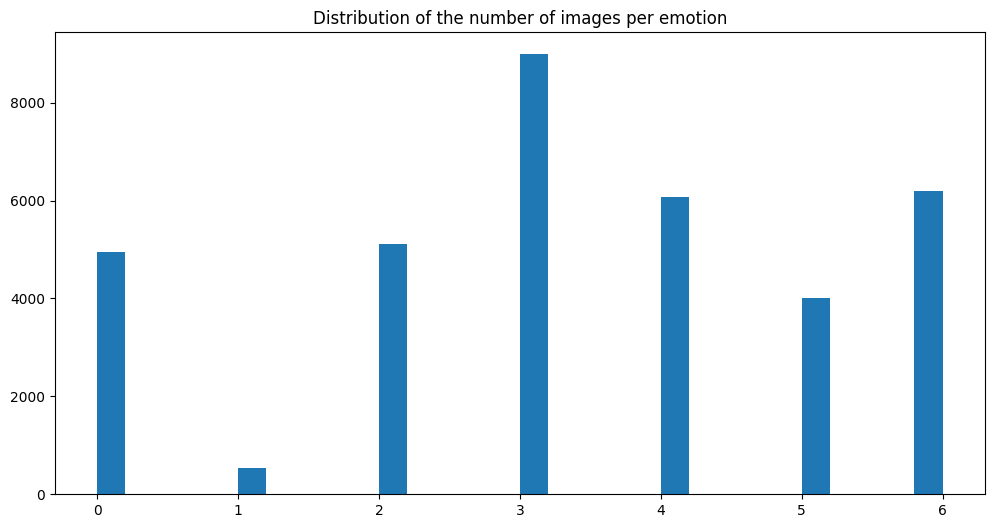

In [14]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [15]:
train.shape

(28709, 3)

In [16]:
test.shape

(3589, 3)

### Create the dataset

In [17]:
shape_x = 48
shape_y = 48

In [18]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [19]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

### Define the number of classes

In [20]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [21]:
#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

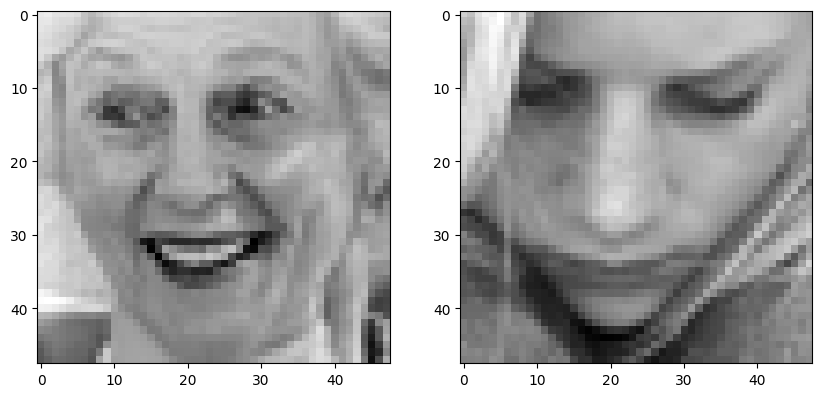

In [22]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
# plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
# plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

### Detect faces

In [23]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = '../../Models_face_detection_xml/FaceDetect/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [24]:
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        x, y, w, h = det
    
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        vertical_offset = int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray transform image
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        #Zoom 
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

### Initial picture

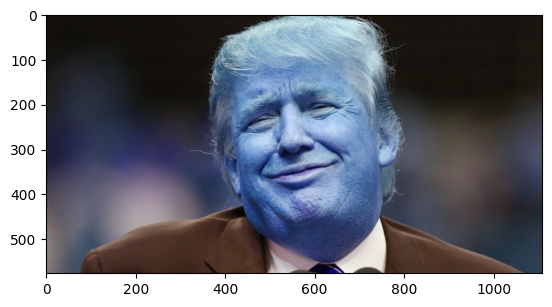

In [25]:
trump = "../../Test_sample/Images/Test_Images/trump.jpg"
trump_face = cv2.imread(trump, cv2.COLOR_BGR2RGB)
plt.imshow(trump_face)

### Extracted face

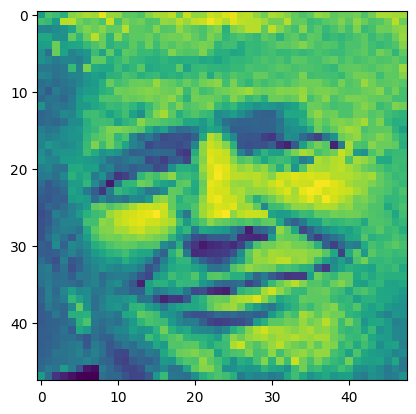

In [26]:
face = extract_face_features(detect_face(trump_face))[0]
plt.imshow(face)

### Deep Learning Model Architecture

#### A first simple model

In [27]:
def createModel():
    
    #Model Initialization
    model = Sequential() 
    
    #Adding Input Layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    
    #Adding more layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
  
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.6))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

#### Prevent Overfitting

In [28]:
def createModel2():
    
    #Model Initialization
    model = Sequential() 
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
 
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

#### Go Deeper

In [29]:
def createModel3():
    
    #Model Initialization
    model = Sequential() 
    
    model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))
    
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(512, activation='relu'))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

In [30]:
model = createModel3()

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 20)        200       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 30)        5430      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 30)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 30)       120       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 30)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 40)        1

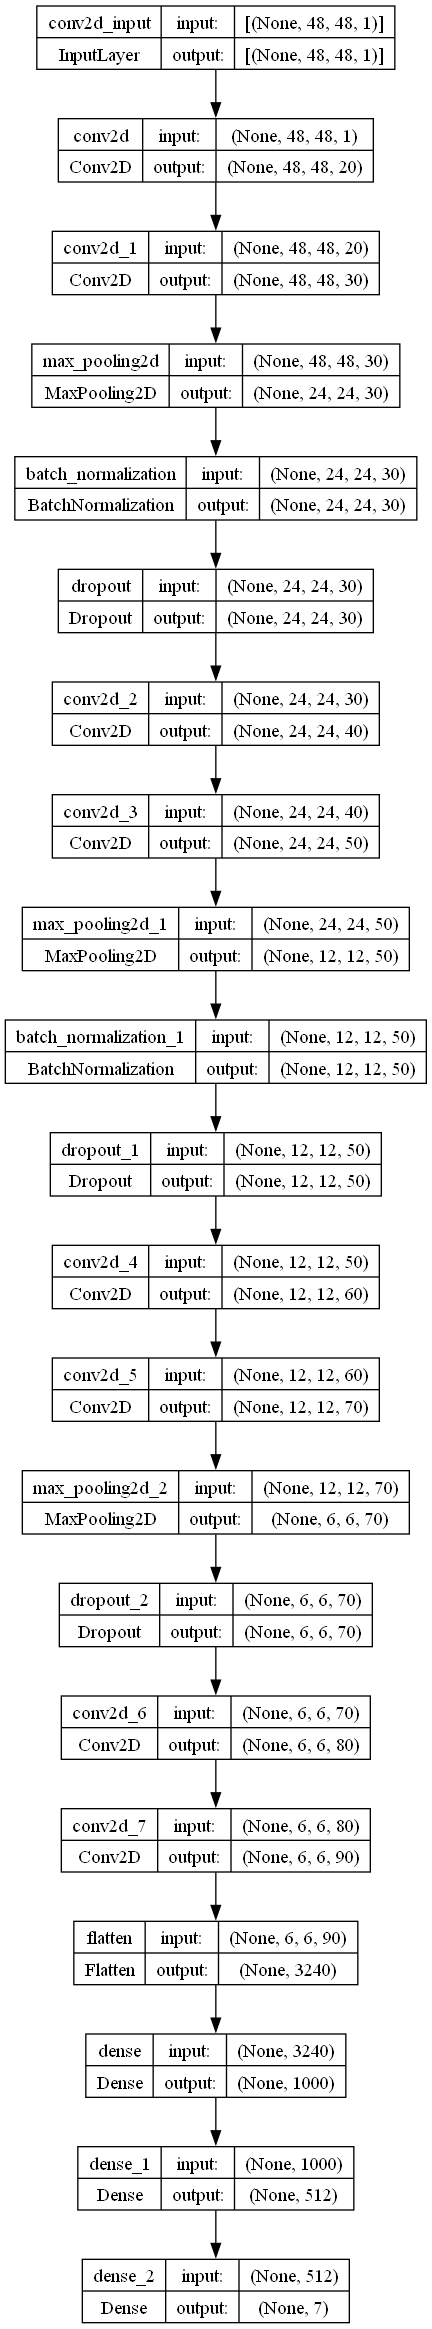

In [32]:
plot_model(model, to_file='../../Test_sample/Images/Model_Images/model_plot.png', show_shapes=True, show_layer_names=True)

### Visual layers and output

In [33]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [34]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

In [35]:
trump = '../../Test_sample/Images/Test_Images/trump.jpg'
trump_face = cv2.imread(trump)
face = extract_face_features(detect_face(trump_face))[0]

to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

c:\Users\Kumar Malay\anaconda3\envs\TFC\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


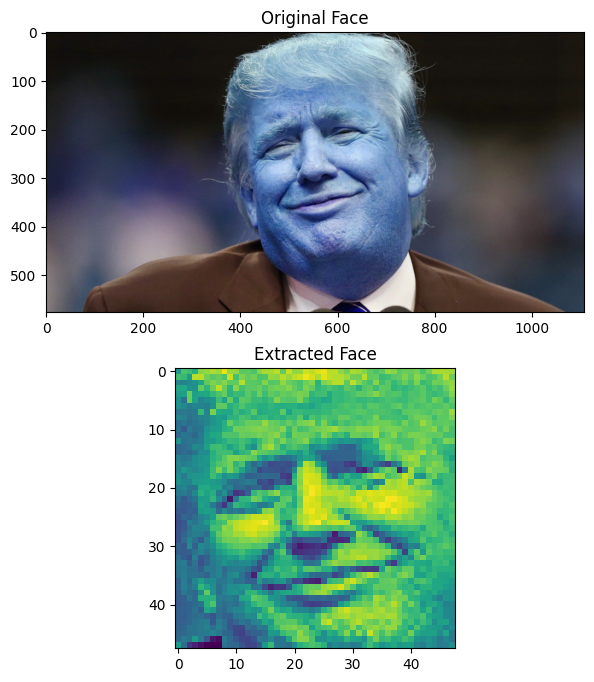

In [36]:
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.title("Original Face")
plt.imshow(trump_face)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

C:\Users\Kumar Malay\AppData\Local\Temp\ipykernel_3100\2292366249.py:10: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\Kumar Malay\AppData\Local\Temp\ipykernel_3100\2292366249.py:13: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


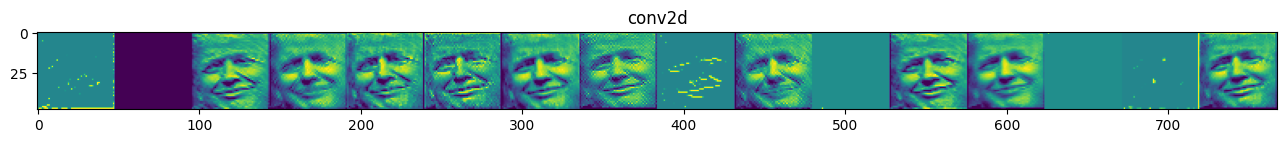

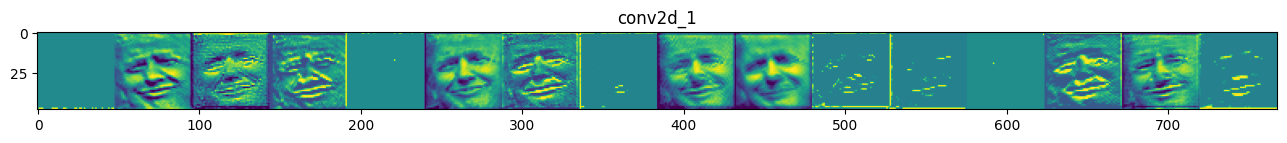

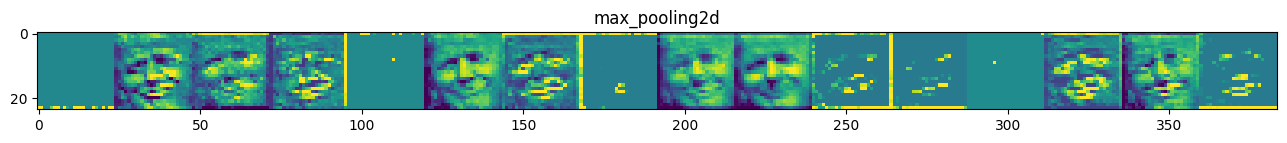

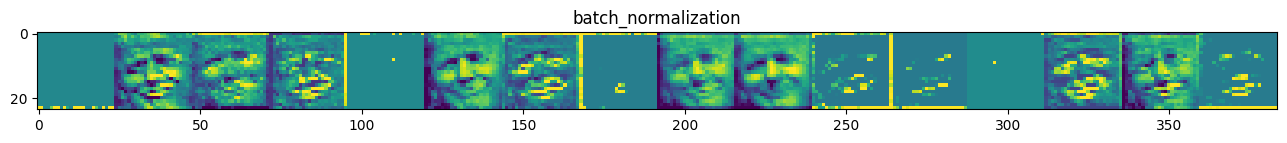

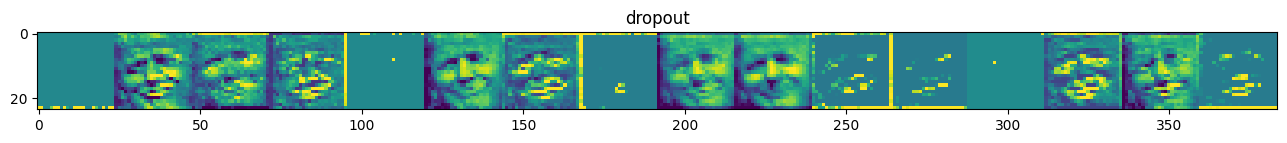

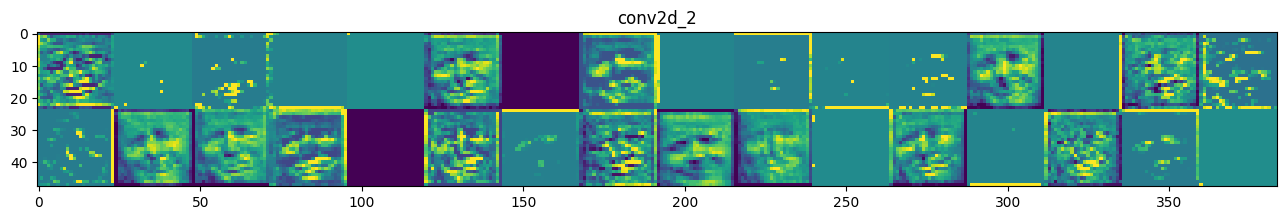

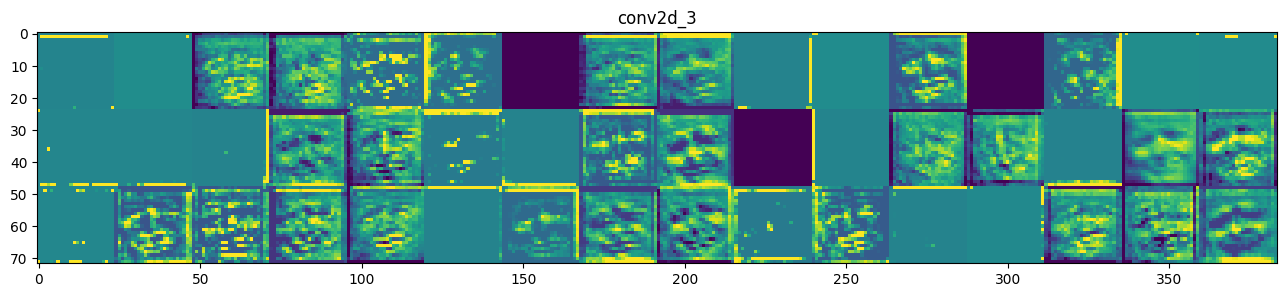

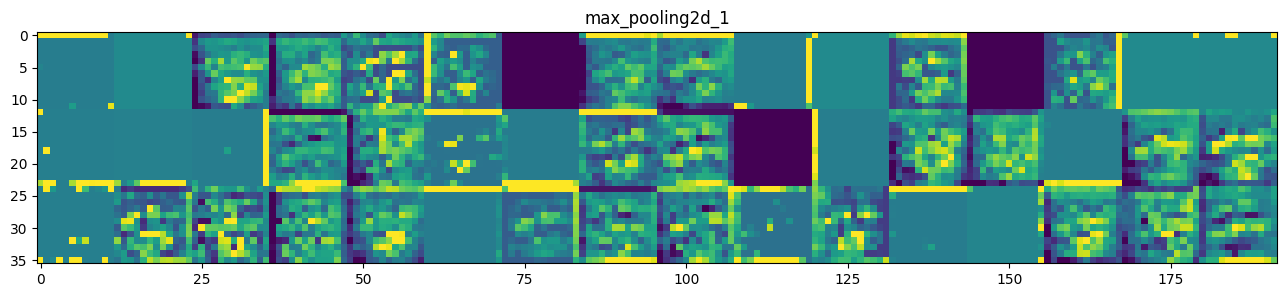

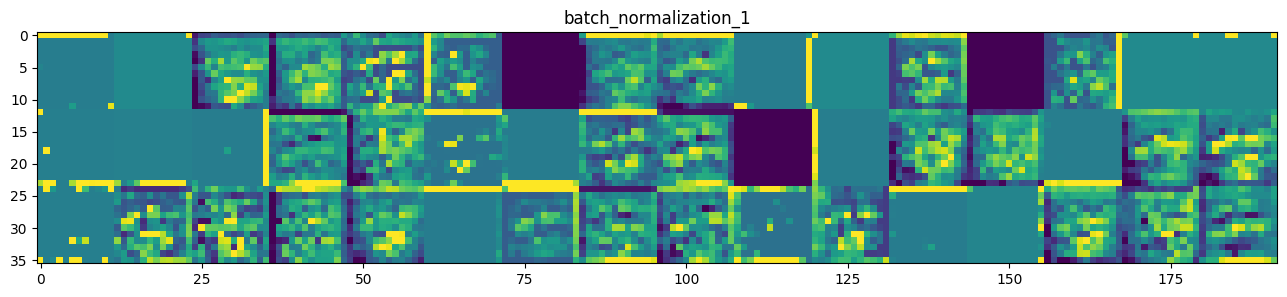

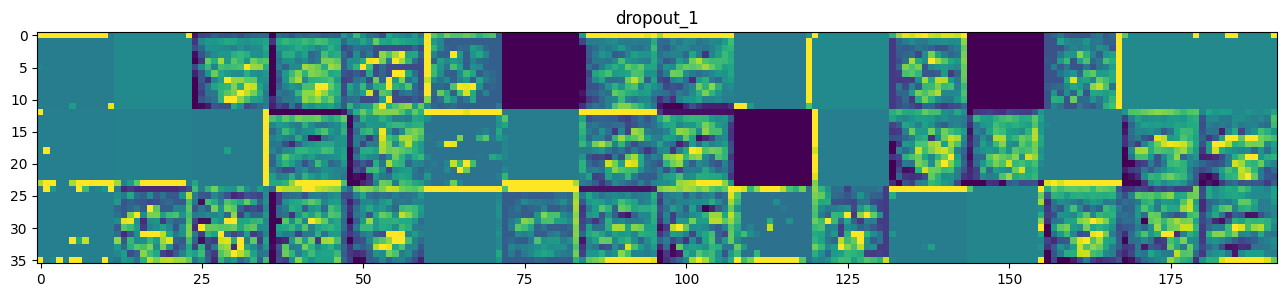

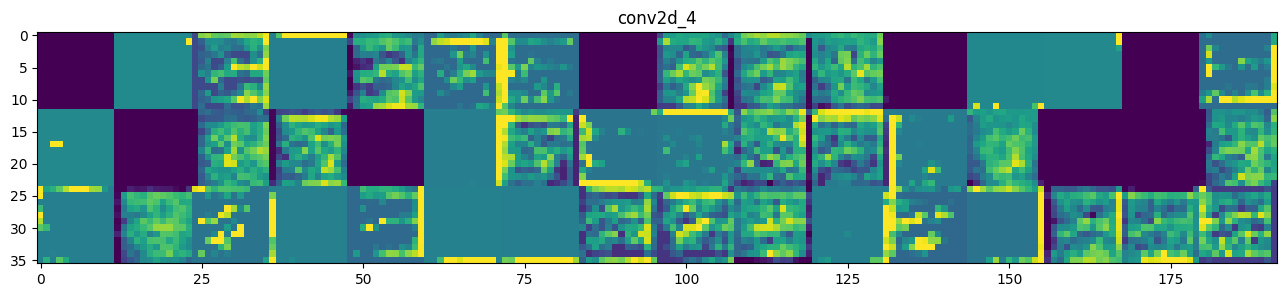

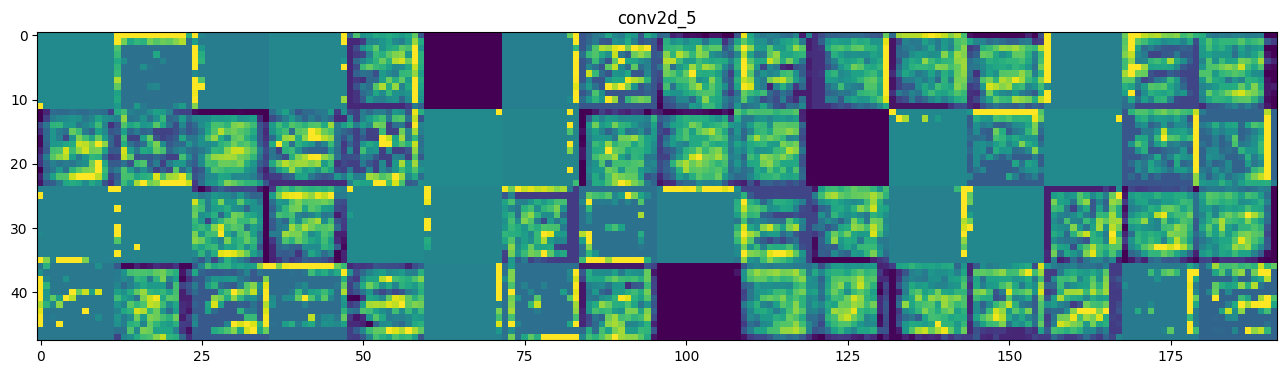

In [37]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Train Model

In [38]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False
)     # randomly flip images

In [39]:
#Creating 2nd model and training(fitting)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 256
epochs = 50

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(test_data, test_labels_one_hot)
)

Epoch 1/50


C:\Users\Kumar Malay\AppData\Local\Temp\ipykernel_3100\573193291.py:9: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


113/113 [==============================] - ETA: 0s - batch: 56.0000 - size: 254.0619 - loss: 1.8226 - accuracy: 0.2512

c:\Users\Kumar Malay\anaconda3\envs\TFC\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


113/113 [==============================] - 18s 125ms/step - batch: 56.0000 - size: 254.0619 - loss: 1.8226 - accuracy: 0.2512 - val_loss: 1.8302 - val_accuracy: 0.2494
Epoch 2/50
113/113 [==============================] - 14s 122ms/step - batch: 56.0000 - size: 254.0619 - loss: 1.6968 - accuracy: 0.3127 - val_loss: 1.8657 - val_accuracy: 0.1697
Epoch 3/50
113/113 [==============================] - 12s 107ms/step - batch: 56.0000 - size: 254.0619 - loss: 1.5745 - accuracy: 0.3818 - val_loss: 1.8088 - val_accuracy: 0.3179
Epoch 4/50
113/113 [==============================] - 12s 106ms/step - batch: 56.0000 - size: 254.0619 - loss: 1.4597 - accuracy: 0.4330 - val_loss: 1.5308 - val_accuracy: 0.3873
Epoch 5/50
113/113 [==============================] - 12s 106ms/step - batch: 56.0000 - size: 254.0619 - loss: 1.3869 - accuracy: 0.4654 - val_loss: 1.3133 - val_accuracy: 0.5046
Epoch 6/50
113/113 [==============================] - 12s 106ms/step - batch: 56.0000 - size: 254.0619 - loss: 1.332

### Evaluate the Model

Text(0.5, 1.0, 'Accuracy Curves')

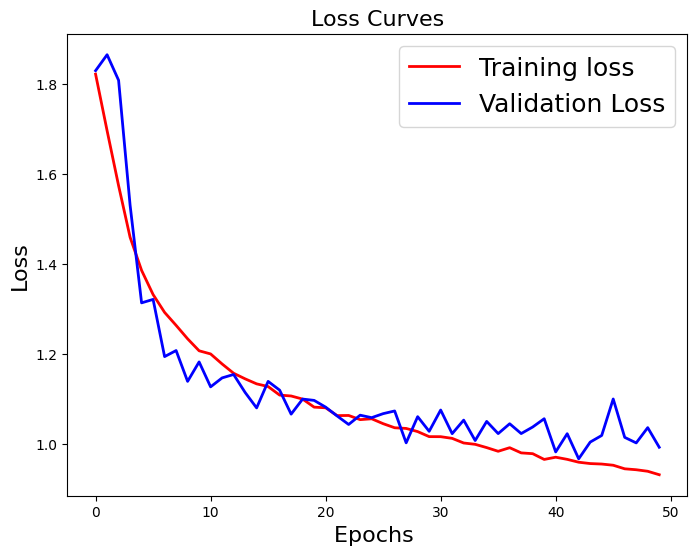

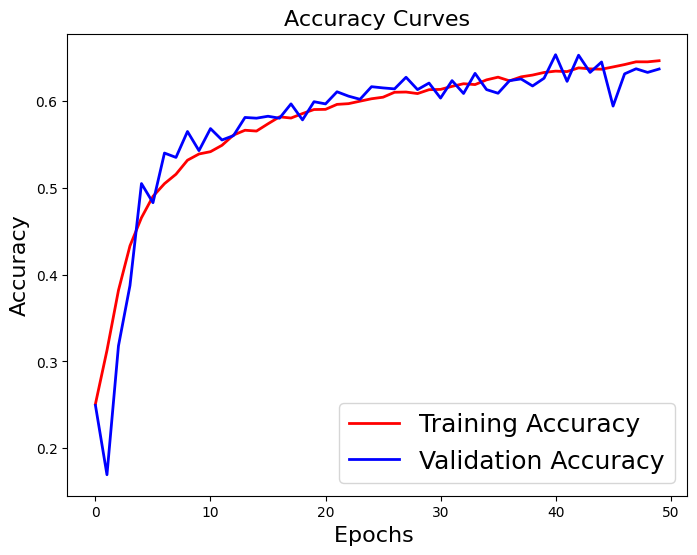

In [40]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Model Save

In [41]:
# save the model weights
json_string = model.to_json()
model.save_weights(local_path + 'fer.h5')
open(local_path + 'fer.json', 'w').write(json_string)

8359